In [55]:
pip install catboost

In [56]:
pip install optuna

In [203]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.2 MB/s eta 0:00:00


In [372]:
# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, make_scorer

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

from deap import base, creator, tools
import random

# Import data

In [58]:
# import data with target
binary_target = pd.read_csv('/content/drive/MyDrive/DataCon/binary_preprocessed.csv')
large_target = pd.read_csv('/content/drive/MyDrive/DataCon/large_no_conc_preprocessed.csv')

#import data with features
binary_df = pd.read_csv('/content/drive/MyDrive/DataCon/binary_basic_features_.csv')
large_df = pd.read_csv('/content/drive/MyDrive/DataCon/large_no_conc_basic_features.csv')

# Important functions

In [59]:
def find_significant_correlations(df, target_column, correlation_threshold=0.4):
    """
    Функция для нахождения названий столбцов, коррелирующих с указанным таргет-столбцом
    более чем на заданный порог по модулю.

    :param df: pandas DataFrame, содержащий данные
    :param target_column: str, название таргет-столбца
    :param correlation_threshold: float, порог корреляции по модулю (по умолчанию 0.4)
    :return: list, список названий столбцов
    """
    # Рассчитаем корреляционную матрицу
    correlation_matrix = df.corr()

    # Получим корреляции таргет-столбца
    target_correlations = correlation_matrix[target_column]

    # Отфильтруем корреляции по порогу
    significant_correlations = target_correlations[abs(target_correlations) > correlation_threshold]

    # Исключим сам столбец target_column из результата
    significant_correlations = significant_correlations.drop(target_column)

    # Получим названия столбцов
    significant_columns = significant_correlations.index.tolist()

    return significant_columns

In [60]:
def draw_heatmap(df):
    '''
    Функция для визуализации тепловой карты матрицы корреляций датасета
    '''
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(15, 12))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                linewidths=.5, cbar_kws={"shrink": .8}, square=True)

    # Add title and adjust layout
    plt.title('Correlation Heatmap of df_descriptors', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the heatmap
    plt.show()

Функция используется для `fune-tuning` модели машинного обучения, которая наилучшим образом показала себя в решении заданной задачи.

Fune-Tuning происходит через подбор набора параметров из датасета, демонстрирующий наилучшие метрики.

Метриками для оценки были выбраны: `F1-Score` и `Percision`.
* `F1-score` используется для общей оценки качества модели
* `Percision` используется для оценки выдачи ложноположительных оценок моделью по причине того, что в текущей задаче это является более критичными ошибками.

In [61]:
def tune_classifier_with_correlations(df, target_column, threshold_range, step):
    '''
    Функция для определения наиболее оптимальной границы меры корреляции для
    архитектуры классификационной модели,
    показавшей наилучшие результаты на тестовом прогоне.

    Параметры:
    df: pd.DataFrame - содержит данные
    target_columns: pd.Series - содержит таргетный параметр
    threshold_range: tuple - содержит границы величины корреляций
    step: float - содержит шаг между величинами корреляции

    '''
    results = []

    for threshold in np.arange(threshold_range[0], threshold_range[1], step):

        # Find significant features based on the current threshold
        significant_columns = find_significant_correlations(df, target_column, threshold)

        if not significant_columns:
            print(f"No significant features found for threshold: {threshold:.2f}")
            continue

        # Prepare the data
        X = df[significant_columns]
        y = df[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Define and train the model
        model = CatBoostClassifier(learning_rate=0.1, iterations=1000, depth=6, verbose=0)
        model.fit(X_train, y_train)

        # Predict and evaluate the model
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        results.append((threshold, f1, precision))
        print(
            f'''
            ---------------------------------
            Threshold: {threshold:.2f} \n
            F1 Score: {f1:.4f} \n
            Precision: {precision:.4f} \n
            '''
            )

    return

Функция используется для fune-tuning модели машинного обучения, которая наилучшим образом показала себя в решении заданной задачи.

Fune-Tuning происходит через подбор набора параметров из датасета, демонстрирующий наилучшие метрики.

Функция охватывает наиболее широкую выборку метрик для оценки

In [62]:
def tune_regression_with_correlations(df, target_column, threshold_range, step):
    '''
    Функция для определения наиболее оптимальной границы меры корреляции для
    архитектуры регрессионной модели, показавшей наилучшие результаты на тестовом прогоне.

    Параметры:
    df: pd.DataFrame - содержит данные
    target_columns: pd.Series - содержит таргетный параметр
    threshold_range: tuple - содержит границы величины корреляций
    step: float - содержит шаг между величинами корреляции

    '''
    results = []

    for threshold in np.arange(threshold_range[0], threshold_range[1], step):

        # Find significant features based on the current threshold
        significant_columns = find_significant_correlations(df, target_column, threshold)

        if not significant_columns:
            print(f"No significant features found for threshold: {threshold:.2f}")
            continue

        # Prepare the data
        X = df[significant_columns]
        y = df[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Создание и обучение модели XGBoost
        xg_reg = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4
            )
        xg_reg.fit(X_train, y_train)

        # Предсказание на тестовой выборке
        y_pred = xg_reg.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(
            f'''
            ---------------------------------
            Threshold: {threshold:.2f} \n
            MSE: {mse:.2f} \n
            MAE: {mae:.2f} \n
            RMSE: {rmse:.2f} \n
            R^2: {r2:.2f}
            '''
            )

    return

# Model building

## Classification

Текущей главе проводится подготовка данных и обучение моделий для решения задач классификации. Т.е. определение, является ли предложенный пептид CPP или нет.

### Important features

In [63]:
# Объединяем датасет фичей с датасетом, содержащий таргет
full_binary_df = pd.concat([
    binary_target.reset_index().drop(columns='index') ,
    binary_df.reset_index().drop(columns='index')
], axis=1, ignore_index=False)

# Убираем дубли столбцов
full_binary_df = full_binary_df.loc[:,~full_binary_df.columns.duplicated()]
full_binary_df = full_binary_df.drop(columns=['Unnamed: 0','sequence', 'biotin_o'])

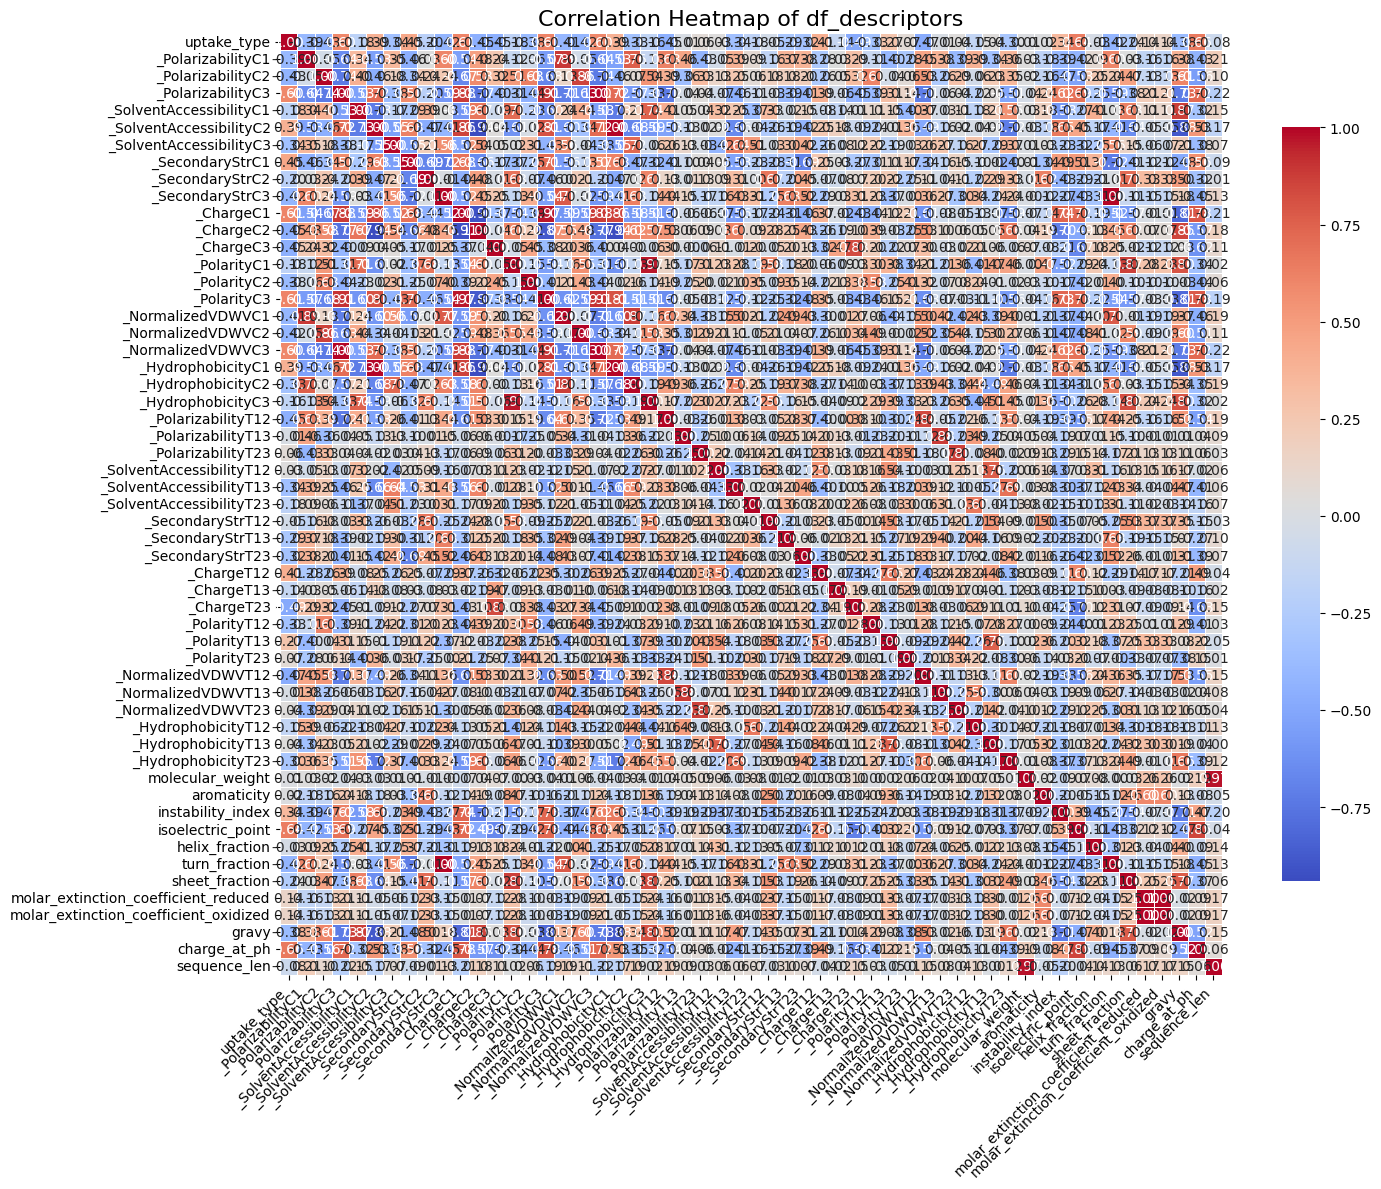

In [64]:
draw_heatmap(full_binary_df)

In [65]:
# Отбираем параметры с коррелирующие с таргетом >0.4 по модулю
important_features = find_significant_correlations(full_binary_df, 'uptake_type')
important_features

['_PolarizabilityC2',
 '_PolarizabilityC3',
 '_SecondaryStrC1',
 '_SecondaryStrC3',
 '_ChargeC1',
 '_ChargeC2',
 '_ChargeC3',
 '_PolarityC3',
 '_NormalizedVDWVC1',
 '_NormalizedVDWVC2',
 '_NormalizedVDWVC3',
 '_PolarizabilityT12',
 '_ChargeT12',
 '_ChargeT23',
 '_NormalizedVDWVT12',
 'isoelectric_point',
 'turn_fraction',
 'charge_at_ph']

Отберём лучшие параметры в X_binary, а таргет в y_binary

In [66]:
X_binary = full_binary_df[important_features]

In [67]:
y_binary = full_binary_df['uptake_type']

### Architertures testing

In [68]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)

#### Logistic regression

In [69]:
# Создание объекта модели линейной регрессии
model = LogisticRegression(
    penalty='l2',           # l2 регуляризация
    C=0.6,                  # Инверсия силы регуляризации
    solver='lbfgs',         # Метод оптимизации
    max_iter=400,           # Максимальное количество итераций
    tol=1e-4,               # Толерантность к остановке
    class_weight='balanced',# Балансировка классов
    multi_class='auto',     # Тип многоцелевой стратегии
    warm_start=False        # Теплый старт
)

# Обучение модели на тренировочной выборке
model.fit(X_train, y_train)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.173
R квадрат для тестовой выборки: 0.304
AUC: 0.824
F1 Score: 0.806
Precision: 0.833


Text(50.722222222222214, 0.5, 'Results')

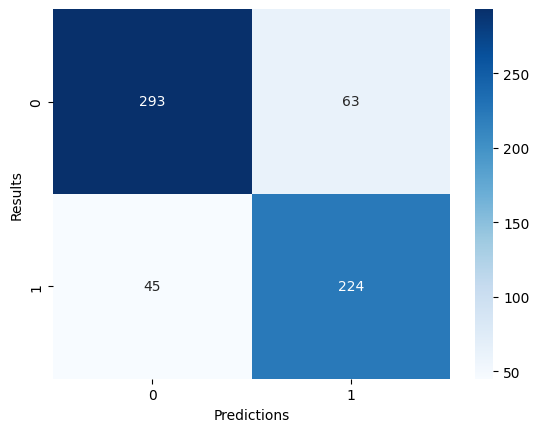

In [70]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

#### Random forest

In [71]:
# Создание объекта модели рандомного леса
model = RandomForestClassifier(
    n_estimators=1000,            # Количество деревьев
    max_depth=7,                # Максимальная глубина деревьев
    min_samples_split=5,         # Минимальное количество образцов для разделения узла
    min_samples_leaf=2,          # Минимальное количество образцов в листьях
    max_features='sqrt',         # Количество признаков для поиска наилучшего разбиения
    bootstrap=False,              # Использовать выборку с возвратом
    random_state=0)

# Обучение модели на тренировочной выборке
model.fit(X_train, y_train)

# Предсказание значений для тестовой выборки
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.136
R квадрат для тестовой выборки: 0.452
AUC: 0.858
F1 Score: 0.842
Precision: 0.901


Text(50.722222222222214, 0.5, 'Results')

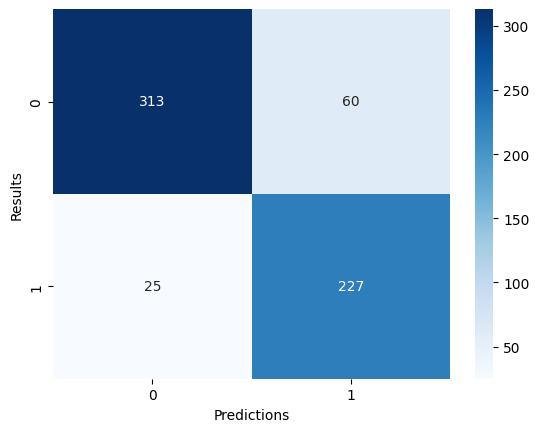

In [72]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

#### CatBoost

In [73]:
# Создание и обучение модели CatBoost
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=9,
    l2_leaf_reg=0.1,
    loss_function='Logloss',
    verbose=100
)

model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

0:	learn: 0.5671389	total: 66.1ms	remaining: 1m 6s
100:	learn: 0.0130429	total: 5.92s	remaining: 52.6s
200:	learn: 0.0023736	total: 16.8s	remaining: 1m 6s
300:	learn: 0.0012721	total: 23s	remaining: 53.4s
400:	learn: 0.0011847	total: 29.7s	remaining: 44.4s
500:	learn: 0.0011834	total: 35.7s	remaining: 35.6s
600:	learn: 0.0011826	total: 41s	remaining: 27.2s
700:	learn: 0.0011540	total: 46.8s	remaining: 20s
800:	learn: 0.0011483	total: 49.4s	remaining: 12.3s
900:	learn: 0.0011473	total: 51.9s	remaining: 5.71s
999:	learn: 0.0011462	total: 54.5s	remaining: 0us
Среднеквадратическая ошибка для тестовой выборки: 0.099
R квадрат для тестовой выборки: 0.601
AUC: 0.898
F1 Score: 0.888
Precision: 0.918


Text(50.722222222222214, 0.5, 'Results')

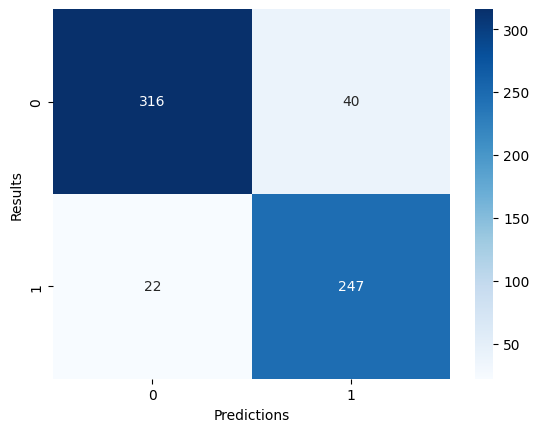

In [74]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

#### XGBoost

In [75]:
# Определение модели XGBoost
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Функция потерь для бинарной классификации
    booster='gbtree',             # Тип бустера, например, дерево решений (можно также 'gblinear' или 'dart')
    n_estimators=100,             # Количество деревьев в ансамбле
    learning_rate=0.1,            # Скорость обучения
    max_depth=6,                  # Глубина деревьев
    min_child_weight=1,           # Минимальное количество образцов в узле
    gamma=0,                      # Минимальное значение потерь для разделения узла
    subsample=0.8,                # Доля образцов для каждого дерева
    colsample_bytree=0.8,         # Доля признаков для каждого дерева
    scale_pos_weight=1,           # Масштаб для взвешивания положительных классов
    random_state=42               # Случайное начальное состояние для воспроизводимости
)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.101
R квадрат для тестовой выборки: 0.594
AUC: 0.897
F1 Score: 0.888
Precision: 0.903


Text(50.722222222222214, 0.5, 'Results')

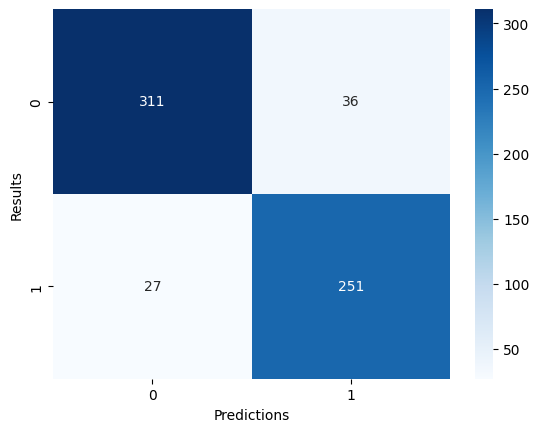

In [76]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

#### Naive Bayes

In [77]:
# Определение модели Naive Bayes
model = BernoulliNB()

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.2
R квадрат для тестовой выборки: 0.195
AUC: 0.8
F1 Score: 0.786
Precision: 0.772


Text(50.722222222222214, 0.5, 'Results')

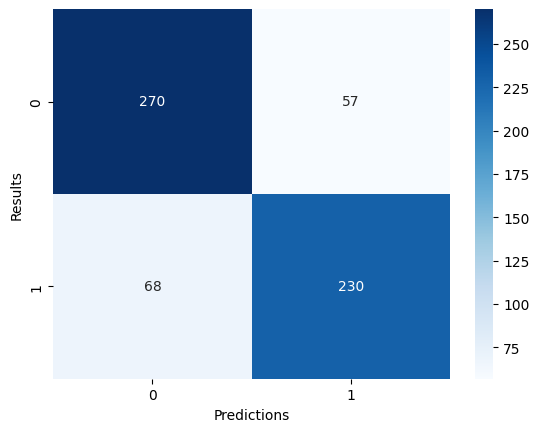

In [78]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

#### K-Nearest Neighbors

In [79]:
# Определение модели KNN
model = KNeighborsClassifier(
    n_neighbors=5,            # Количество ближайших соседей
    weights='uniform',        # Как веса соседей учитываются ('uniform' или 'distance')
    algorithm='auto',         # Алгоритм для вычисления соседей ('auto', 'ball_tree', 'kd_tree', 'brute')
    p=2,                      # Параметр для вычисления расстояния, p=2 соответствует евклидовой метрике
    n_jobs=-1                 # Количество потоков для вычислений, -1 означает использование всех доступных ядер
)

# Обучение модели
model.fit(X_train, y_train)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

Среднеквадратическая ошибка для тестовой выборки: 0.163
R квадрат для тестовой выборки: 0.343
AUC: 0.831
F1 Score: 0.811
Precision: 0.866


Text(50.722222222222214, 0.5, 'Results')

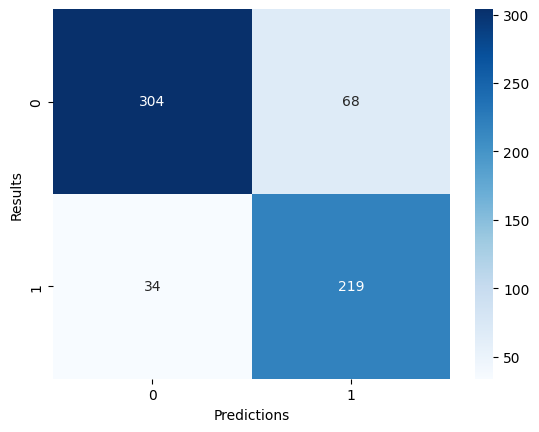

In [80]:
cfm = confusion_matrix(y_pred, y_test)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predictions')
plt.ylabel('Results')

Поскольку `CatBoost` показал лучшие базовые показатели F1-score и Precision, принято решение взять модель на валидацию с целью улучшить метрики.

#### Best model

Поскольку на тестовом прогоне архитектур для классификации, наилучшие целевые метрики показал `CatBoost`, берём его в качестве базовой модели для дальнейшей доработки параметров.

В первую очередь, попробуем откалибровать наиболее качественные параметры, характеризующие таргет.

In [81]:
tune_classifier_with_correlations(full_binary_df, 'uptake_type', (0.1, 0.2), 0.01)


            ---------------------------------
            Threshold: 0.10 

            F1 Score: 0.8955 

            Precision: 0.9155 

            

            ---------------------------------
            Threshold: 0.11 

            F1 Score: 0.8955 

            Precision: 0.9155 

            

            ---------------------------------
            Threshold: 0.12 

            F1 Score: 0.8955 

            Precision: 0.9155 

            

            ---------------------------------
            Threshold: 0.13 

            F1 Score: 0.8955 

            Precision: 0.9155 

            

            ---------------------------------
            Threshold: 0.14 

            F1 Score: 0.9074 

            Precision: 0.9356 

            

            ---------------------------------
            Threshold: 0.15 

            F1 Score: 0.8969 

            Precision: 0.9258 

            

            ---------------------------------
            Threshold: 0.16 

     

Исходя из подбора наиболее оптимательного Threshold, останавливаемся на границе 0.16, как граница корреляции параметров с наилучшими показатерями (F1 Score: 0.9030, Precision: 0.9287)

In [166]:
# Отбираем параметры, коррелирующие с таргетом >0.16 по модулю
important_features = find_significant_correlations(
    full_binary_df, 'uptake_type', 0.16
    )

In [167]:
important_features

['_PolarizabilityC1',
 '_PolarizabilityC2',
 '_PolarizabilityC3',
 '_SolventAccessibilityC1',
 '_SolventAccessibilityC2',
 '_SolventAccessibilityC3',
 '_SecondaryStrC1',
 '_SecondaryStrC2',
 '_SecondaryStrC3',
 '_ChargeC1',
 '_ChargeC2',
 '_ChargeC3',
 '_PolarityC1',
 '_PolarityC2',
 '_PolarityC3',
 '_NormalizedVDWVC1',
 '_NormalizedVDWVC2',
 '_NormalizedVDWVC3',
 '_HydrophobicityC1',
 '_HydrophobicityC2',
 '_HydrophobicityC3',
 '_PolarizabilityT12',
 '_SolventAccessibilityT13',
 '_SolventAccessibilityT23',
 '_SecondaryStrT13',
 '_SecondaryStrT23',
 '_ChargeT12',
 '_ChargeT23',
 '_PolarityT12',
 '_PolarityT13',
 '_NormalizedVDWVT12',
 '_HydrophobicityT23',
 'instability_index',
 'isoelectric_point',
 'turn_fraction',
 'sheet_fraction',
 'gravy',
 'charge_at_ph']

In [168]:
X_binary = full_binary_df[important_features]
y_binary = full_binary_df['uptake_type']

In [169]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.3, random_state=42)

In [170]:
# Создание и обучение модели CatBoost
class_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=3,
    loss_function='Logloss',
    verbose=100
)

class_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = class_model.predict(X_test)

# Вычисление среднеквадратической ошибки для тестовой выборки
mse = mean_squared_error(y_test, y_pred)

# Округление ответа до тысячных
mse_rounded = round(mse, 3)

print("Среднеквадратическая ошибка для тестовой выборки:", mse_rounded)

# Вычисление R квадрата для тестовой выборки
r2 = r2_score(y_test, y_pred)

# Округление ответа до тысячных
r2 = round(r2, 3)

print("R квадрат для тестовой выборки:", r2)

# Расчет AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {round(auc, 3)}')

# Расчет F1-score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {round(f1, 3)}')

# Расчет Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {round(precision, 3)}')

0:	learn: 0.6123200	total: 97.4ms	remaining: 1m 37s
100:	learn: 0.1028681	total: 2.49s	remaining: 22.1s
200:	learn: 0.0417036	total: 4.44s	remaining: 17.6s
300:	learn: 0.0221679	total: 6.03s	remaining: 14s
400:	learn: 0.0136262	total: 7.62s	remaining: 11.4s
500:	learn: 0.0098838	total: 8.56s	remaining: 8.53s
600:	learn: 0.0083256	total: 9.44s	remaining: 6.26s
700:	learn: 0.0068154	total: 10.5s	remaining: 4.48s
800:	learn: 0.0061293	total: 12.3s	remaining: 3.06s
900:	learn: 0.0055062	total: 14.1s	remaining: 1.55s
999:	learn: 0.0053049	total: 15.3s	remaining: 0us
Среднеквадратическая ошибка для тестовой выборки: 0.09
R квадрат для тестовой выборки: 0.641
AUC: 0.909
F1 Score: 0.903
Precision: 0.929


Уже после подбора наиболее оптимальных параметров, модель показывает хорошие результаты с цифрами: `F1 Score` - `0.903` и `Precision` - `0.929`.

Это говорит о том, что модель способна хорошо классифицировать пептиды, по-минимуму допуская ложноположительные предсказания (лишь в `~7%` случаев).

#### Validation model

In [86]:
# Использование StratifiedKFold для кросс-валидации
skf = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(
    model,
    full_binary_df[important_features],
    full_binary_df['uptake_type'],
    cv=skf,
    scoring='precision'
    )
print(f"Stratified Cross-validated Percision scores: {cv_scores}")
print(f"Mean Percision score: {cv_scores.mean()}")

0:	learn: 0.6140375	total: 10.4ms	remaining: 10.4s
100:	learn: 0.1160218	total: 993ms	remaining: 8.84s
200:	learn: 0.0538869	total: 1.97s	remaining: 7.82s
300:	learn: 0.0288237	total: 2.93s	remaining: 6.8s
400:	learn: 0.0176833	total: 3.89s	remaining: 5.82s
500:	learn: 0.0123465	total: 4.84s	remaining: 4.82s
600:	learn: 0.0093357	total: 5.8s	remaining: 3.85s
700:	learn: 0.0080484	total: 6.75s	remaining: 2.88s
800:	learn: 0.0068142	total: 7.68s	remaining: 1.91s
900:	learn: 0.0060954	total: 8.61s	remaining: 946ms
999:	learn: 0.0056071	total: 9.53s	remaining: 0us
0:	learn: 0.6215986	total: 8.73ms	remaining: 8.73s
100:	learn: 0.1252055	total: 1.71s	remaining: 15.2s
200:	learn: 0.0540879	total: 3.52s	remaining: 14s
300:	learn: 0.0295480	total: 5.01s	remaining: 11.6s
400:	learn: 0.0185424	total: 5.89s	remaining: 8.79s
500:	learn: 0.0120880	total: 6.74s	remaining: 6.72s
600:	learn: 0.0094666	total: 7.59s	remaining: 5.04s
700:	learn: 0.0077349	total: 8.49s	remaining: 3.62s
800:	learn: 0.006608

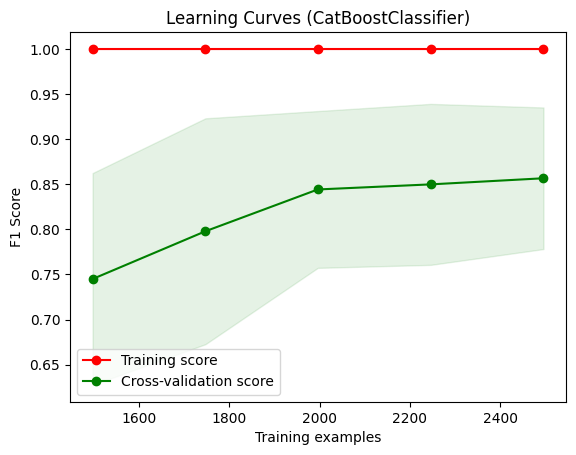

In [88]:
# Построение кривых обучения
train_sizes, train_scores, test_scores = learning_curve(
    model,
    full_binary_df[important_features],
    full_binary_df['uptake_type'],
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves (CatBoostClassifier)")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

### Conclusion

Косс-валидация модели показала, что по метрики `Percision` модель имеет достаточно малый разброс, демонстрируя устойчивые показатели при разных выборках.

В то же время `F1-score` имеет некоторые колебания, что вместе устойчивостью `Percision` может говорить о колебаниях в предсказании ложноотрицательных результатов.

В заключении, можно сказать, что на предложенной выборке, модель показывает достаточно хорошие результаты с акцентом на избегание ложноположительных результатов.

## Regression

Текущая задача отличается от предыдущей в первую очередь тем, что в данном случае нам требуется предсказать не бинарную, а численную метрицу проницаемости пептида.

In [89]:
large_target.head(5)

Unnamed: 0      Peptide     Cell line        Cargo  PubmedID Uptake  \
0           0  Tat (49-57)  Jurkat cells  Fluorescein  11087855    650   
1           1  Tat (49-56)  Jurkat cells  Fluorescein  11087855  31.25   
2           2  Tat (49-55)  Jurkat cells  Fluorescein  11087855     10   
3           3  Tat (50-57)  Jurkat cells  Fluorescein  11087855   22.5   
4           4  Tat (51-57)  Jurkat cells  Fluorescein  11087855     20   

                         Units  Time  Temp.          Method             Type  \
0  Mean Fluorescence intensity  15.0   23.0  Flow cytometry  Cellular uptake   
1  Mean Fluorescence intensity  10.0   23.0  Flow cytometry  Cellular uptake   
2  Mean Fluorescence intensity  10.0   23.0  Flow cytometry  Cellular uptake   
3  Mean Fluorescence intensity  10.0   23.0  Flow cytometry  Cellular uptake   
4  Mean Fluorescence intensity  10.0   23.0  Flow cytometry  Cellular uptake   

    Sequence  new_uptake  nht_tail  acylated_terminal cleaned_sequence  
0  RKKRRQRRR      650.00         0                  0        RKKRRQRRR  
1   RKKRRQRR       31.25         0                  0         RKKRRQRR  
2    RKKRRQR       10.00         0                  0          RKKRRQR  
3   KKRRQRRR       22.50         0                  0         KKRRQRRR  
4    KRRQRRR       20.00         0                  0          KRRQRRR

In [90]:
large_df.head(5)

Unnamed: 0 cleaned_sequence  _PolarizabilityC1  _PolarizabilityC2  \
0           0        RKKRRQRRR                0.0              0.111   
1           1         RKKRRQRR                0.0              0.125   
2           2          RKKRRQR                0.0              0.143   
3           3         KKRRQRRR                0.0              0.125   
4           4          KRRQRRR                0.0              0.143   

   _PolarizabilityC3  _SolventAccessibilityC1  _SolventAccessibilityC2  \
0              0.889                      0.0                      1.0   
1              0.875                      0.0                      1.0   
2              0.857                      0.0                      1.0   
3              0.875                      0.0                      1.0   
4              0.857                      0.0                      1.0   

   _SolventAccessibilityC3  _SecondaryStrC1  _SecondaryStrC2  ...  \
0                      0.0              1.0              0.0  ...   
1                      0.0              1.0              0.0  ...   
2                      0.0              1.0              0.0  ...   
3                      0.0              1.0              0.0  ...   
4                      0.0              1.0              0.0  ...   

   isoelectric_point  helix_fraction  turn_fraction  sheet_fraction  \
0          11.999968        0.222222            0.0             0.0   
1          11.999968        0.250000            0.0             0.0   
2          11.999968        0.285714            0.0             0.0   
3          11.999968        0.250000            0.0             0.0   
4          11.999968        0.142857            0.0             0.0   

   molar_extinction_coefficient_reduced  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   molar_extinction_coefficient_oxidized     gravy   sequence  charge_at_ph  \
0                                      0 -4.255556  RKKRRQRRR      7.758044   
1                                      0 -4.225000   RKKRRQRR      6.758054   
2                                      0 -4.185714    RKKRRQR      5.758064   
3                                      0 -4.225000   KKRRQRRR      6.758054   
4                                      0 -4.271429    KRRQRRR      5.759053   

   sequence_len  
0             9  
1             8  
2             7  
3             8  
4             7  

[5 rows x 57 columns]

In [91]:
full_peptide_df = pd.concat([
    large_target.reset_index().drop(columns='index') ,
    large_df.reset_index().drop(columns='index')
], axis=1, ignore_index=False)

# Убираем дубли столбцов
full_peptide_df = full_peptide_df.loc[:,~full_peptide_df.columns.duplicated()]
full_peptide_df = full_peptide_df.drop(
    columns=[
        'Unnamed: 0',
        'Cargo',
        'Peptide',
        'Cell line',
        'PubmedID',
        'Uptake',
        'Type',
        'Sequence',
        'sequence',
        'cleaned_sequence'
        ]
    )

<Axes: >

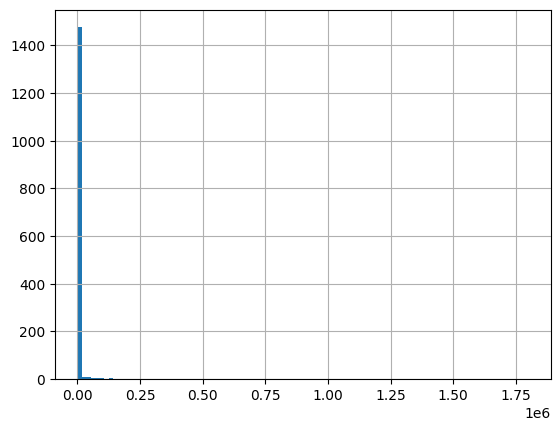

In [93]:
full_peptide_df['new_uptake'].hist(bins=100)

По причине достаточно высокого разброса показателей таргетного параметра регрессии.

Принято решение обрезать данные по 95% перцентилю, как наиболее оптимальный и общепринятый вариант избавления от самых критичных выбросов в датасете.

<Axes: >

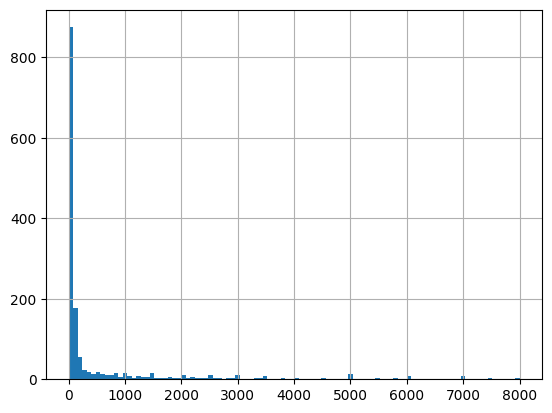

In [94]:
full_peptide_df['new_uptake'][full_peptide_df['new_uptake'] <= full_peptide_df['new_uptake'].quantile(0.95)].dropna().hist(bins=100)

In [95]:
# Удаляем строки, где значение в столбце new_uptake больше 95-го процентиля
filtered_peptide_df = full_peptide_df[
    full_peptide_df['new_uptake'] <= full_peptide_df['new_uptake'].quantile(0.95)
    ]

### Normalisation data

Проведём нормализацию категориальных данных, заменив их на числовые значения.

In [97]:
# Приводим текстовые данные к нижнему регистру
text_columns = filtered_peptide_df.select_dtypes(include=['object']).columns
filtered_peptide_df[text_columns] = filtered_peptide_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-97-83aab5201938>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_peptide_df[text_columns] = filtered_peptide_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [98]:
# Переводим текстовые столбцы в категориальный тип
text_columns = filtered_peptide_df.select_dtypes(include=['object']).columns
filtered_peptide_df[text_columns] = filtered_peptide_df[text_columns].astype('category')

# Получение числовых кодов для категориальных данных
for col in text_columns:
    filtered_peptide_df[col] = filtered_peptide_df[col].cat.codes

<ipython-input-98-e9274f10c501>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_peptide_df[text_columns] = filtered_peptide_df[text_columns].astype('category')
<ipython-input-98-e9274f10c501>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_peptide_df[col] = filtered_peptide_df[col].cat.codes


In [99]:
filtered_peptide_df.head()

Units  Time  Temp.  Method  new_uptake  nht_tail  acylated_terminal  \
0     38  15.0   23.0       5      650.00         0                  0   
1     38  10.0   23.0       5       31.25         0                  0   
2     38  10.0   23.0       5       10.00         0                  0   
3     38  10.0   23.0       5       22.50         0                  0   
4     38  10.0   23.0       5       20.00         0                  0   

   _PolarizabilityC1  _PolarizabilityC2  _PolarizabilityC3  ...  \
0                0.0              0.111              0.889  ...   
1                0.0              0.125              0.875  ...   
2                0.0              0.143              0.857  ...   
3                0.0              0.125              0.875  ...   
4                0.0              0.143              0.857  ...   

   instability_index  isoelectric_point  helix_fraction  turn_fraction  \
0         257.444444          11.999968        0.222222            0.0   
1         216.775000          11.999968        0.250000            0.0   
2         164.485714          11.999968        0.285714            0.0   
3         288.375000          11.999968        0.250000            0.0   
4         328.142857          11.999968        0.142857            0.0   

   sheet_fraction  molar_extinction_coefficient_reduced  \
0             0.0                                     0   
1             0.0                                     0   
2             0.0                                     0   
3             0.0                                     0   
4             0.0                                     0   

   molar_extinction_coefficient_oxidized     gravy  charge_at_ph  sequence_len  
0                                      0 -4.255556      7.758044             9  
1                                      0 -4.225000      6.758054             8  
2                                      0 -4.185714      5.758064             7  
3                                      0 -4.225000      6.758054             8  
4                                      0 -4.271429      5.759053             7  

[5 rows x 61 columns]

### Important features

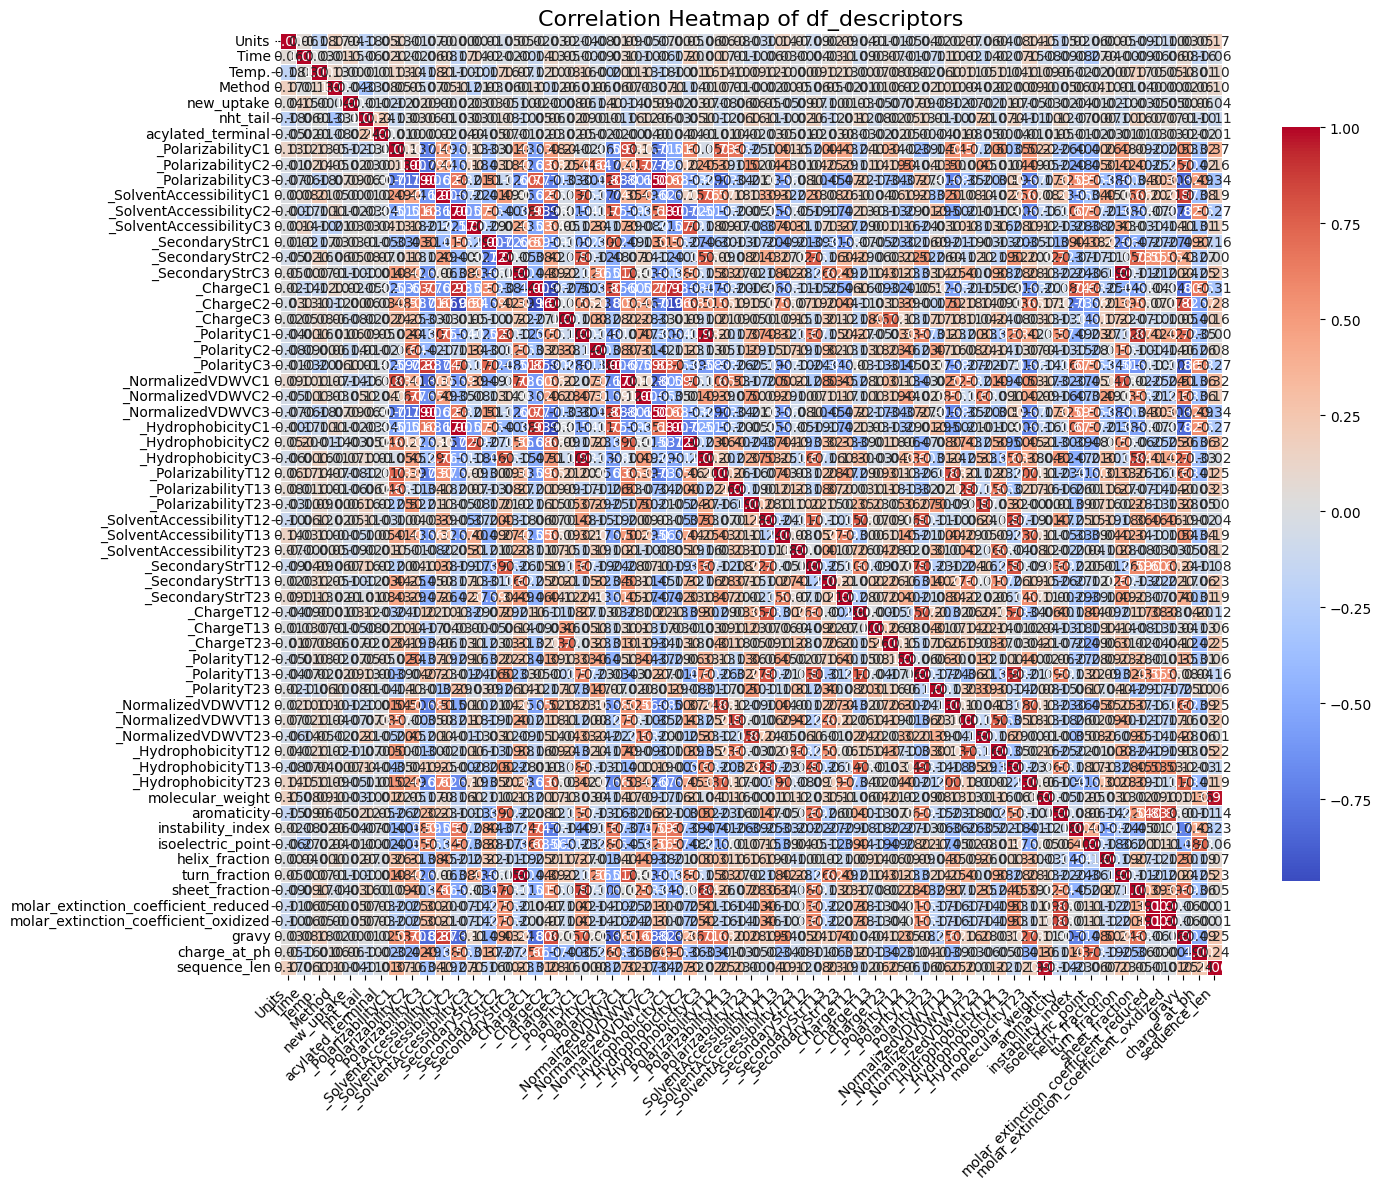

In [100]:
draw_heatmap(filtered_peptide_df)

In [101]:
# Отбираем параметры с коррелирующие с таргетом >0.1 по модулю
important_features = find_significant_correlations(
    filtered_peptide_df, 'new_uptake', 0.01
    )
important_features

['Units',
 'Time',
 'Method',
 'nht_tail',
 'acylated_terminal',
 '_PolarizabilityC1',
 '_PolarizabilityC2',
 '_PolarizabilityC3',
 '_SolventAccessibilityC2',
 '_SolventAccessibilityC3',
 '_SecondaryStrC1',
 '_SecondaryStrC2',
 '_SecondaryStrC3',
 '_ChargeC1',
 '_ChargeC3',
 '_PolarityC1',
 '_PolarityC2',
 '_PolarityC3',
 '_NormalizedVDWVC1',
 '_NormalizedVDWVC2',
 '_NormalizedVDWVC3',
 '_HydrophobicityC1',
 '_HydrophobicityC2',
 '_HydrophobicityC3',
 '_PolarizabilityT12',
 '_PolarizabilityT13',
 '_PolarizabilityT23',
 '_SolventAccessibilityT12',
 '_SolventAccessibilityT13',
 '_SolventAccessibilityT23',
 '_SecondaryStrT12',
 '_SecondaryStrT13',
 '_SecondaryStrT23',
 '_ChargeT12',
 '_ChargeT13',
 '_ChargeT23',
 '_PolarityT12',
 '_PolarityT13',
 '_PolarityT23',
 '_NormalizedVDWVT12',
 '_NormalizedVDWVT13',
 '_NormalizedVDWVT23',
 '_HydrophobicityT12',
 '_HydrophobicityT13',
 '_HydrophobicityT23',
 'molecular_weight',
 'aromaticity',
 'instability_index',
 'helix_fraction',
 'turn_fractio

In [102]:
X_peptide = filtered_peptide_df[important_features]
y_peptide = filtered_peptide_df['new_uptake']

In [103]:
len(filtered_peptide_df)

1448

In [104]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_peptide, y_peptide, test_size=0.2, random_state=42)

### Models building

#### Linear Regression

In [105]:
# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')

Mean Squared Error (MSE): 1341652.4286030561
Mean Absolute Error (MAE): 651.0252381386672
Root Mean Squared Error (RMSE): 1158.297210824172
R-squared (R^2): 0.1015041805559791


#### Lasso

In [106]:
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)

# Предсказание и вычисление метрик
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')

Mean Squared Error (MSE): 1343304.783393512
Mean Absolute Error (MAE): 659.0211628360928
Root Mean Squared Error (RMSE): 1159.010260262398
R-squared (R^2): 0.10039760940549958


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.692e+08, tolerance: 1.871e+05
  model = cd_fast.enet_coordinate_descent(


#### Random Forest

In [107]:
model = RandomForestRegressor(
    n_estimators=500,    # Количество деревьев
    random_state=0
    )
model.fit(X_train, y_train)

# Предсказание и вычисление метрик
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

Mean Squared Error (MSE): 777479.5651
Mean Absolute Error (MAE): 365.1727
Root Mean Squared Error (RMSE): 881.7480
R-squared (R^2): 0.4793


#### Ridge Regression

In [108]:
# Создание и обучение модели Ридж-регрессии
ridge_model = Ridge(alpha=1.0)  # alpha контролирует степень регуляризации
ridge_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = ridge_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'Ridge Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

Ridge Regression Model:
  Mean Squared Error (MSE): 1375578.4213
  Mean Absolute Error (MAE): 669.8201
  Root Mean Squared Error (RMSE): 1172.8506
  R-squared (R^2): 0.0788


#### ElasticNet

In [109]:
# Создание и обучение модели Elastic Net
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha контролирует степень регуляризации, l1_ratio - баланс между L1 и L2
elastic_net_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = elastic_net_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'Elastic Net Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

Elastic Net Regression Model:
  Mean Squared Error (MSE): 1430600.9896
  Mean Absolute Error (MAE): 694.3561
  Root Mean Squared Error (RMSE): 1196.0773
  R-squared (R^2): 0.0419


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.414e+08, tolerance: 1.871e+05
  model = cd_fast.enet_coordinate_descent(


#### Polynomial Regression

In [110]:
# Создание полиномиальных признаков
degree = 2  # Степень полинома
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Создание и обучение модели линейной регрессии на полиномиальных признаках
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_poly)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'Polynomial Regression Model (degree={degree}):')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

Polynomial Regression Model (degree=2):
  Mean Squared Error (MSE): 9225372252744.1621
  Mean Absolute Error (MAE): 659548.5068
  Root Mean Squared Error (RMSE): 3037329.7899
  R-squared (R^2): -6178170.2053


#### Support Vector Regression

In [111]:
# Создание и обучение модели SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)  # 'rbf' - радиально-базисная функция (ядро)
svr_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = svr_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'Support Vector Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

Support Vector Regression Model:
  Mean Squared Error (MSE): 1519160.2138
  Mean Absolute Error (MAE): 432.1856
  Root Mean Squared Error (RMSE): 1232.5422
  R-squared (R^2): -0.0174


#### XGBoost

In [112]:
# Создание и обучение модели XGBoost
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4
    )
xg_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xg_reg.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 740977.1792
  Mean Absolute Error (MAE): 400.1175
  Root Mean Squared Error (RMSE): 860.8003
  R-squared (R^2): 0.5038


#### CatBoost

In [113]:
# Создание и обучение модели CatBoost
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=7,
    loss_function='RMSE',
    verbose=50  # Отключение вывода сообщений обучения
)
catboost_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = catboost_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

0:	learn: 1246.0587899	total: 14.6ms	remaining: 14.6s
50:	learn: 765.5584432	total: 553ms	remaining: 10.3s
100:	learn: 645.1133052	total: 1.08s	remaining: 9.66s
150:	learn: 520.3082483	total: 1.64s	remaining: 9.2s
200:	learn: 462.2590199	total: 2.17s	remaining: 8.63s
250:	learn: 427.9172724	total: 2.73s	remaining: 8.16s
300:	learn: 402.8515507	total: 3.26s	remaining: 7.57s
350:	learn: 389.1245945	total: 3.8s	remaining: 7.03s
400:	learn: 381.4069464	total: 4.34s	remaining: 6.48s
450:	learn: 375.3788949	total: 4.88s	remaining: 5.94s
500:	learn: 370.4963415	total: 5.4s	remaining: 5.38s
550:	learn: 367.6267060	total: 5.96s	remaining: 4.86s
600:	learn: 365.4059225	total: 6.51s	remaining: 4.32s
650:	learn: 363.9526428	total: 7.09s	remaining: 3.8s
700:	learn: 362.5484227	total: 7.65s	remaining: 3.26s
750:	learn: 361.4416652	total: 8.18s	remaining: 2.71s
800:	learn: 360.6165368	total: 8.73s	remaining: 2.17s
850:	learn: 359.9689733	total: 9.26s	remaining: 1.62s
900:	learn: 359.4703144	total: 9.

#### K-Nearest Neighbors Regression

In [114]:
# Создание и обучение модели KNN
k = 5  # Количество соседей
knn_regressor = KNeighborsRegressor(n_neighbors=k)
knn_regressor.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = knn_regressor.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

  Mean Squared Error (MSE): 1042537.2373
  Mean Absolute Error (MAE): 436.3310
  Root Mean Squared Error (RMSE): 1021.0471
  R-squared (R^2): 0.3018


#### Best model

За основу, как модель с наилучшими показателями метрик, берём модель на основе XGBoost.

В первую очередь проводим отбор границы корреляции параметров.

Fine-tuning for correlation

In [115]:
def tune_model_with_correlations(df, target_column, threshold_range, step):
    results = []

    for threshold in np.arange(threshold_range[0], threshold_range[1], step):

        # Find significant features based on the current threshold
        significant_columns = find_significant_correlations(df, target_column, threshold)

        if not significant_columns:
            print(f"No significant features found for threshold: {threshold:.2f}")
            continue

        # Prepare the data
        X = df[significant_columns]
        y = df[target_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Создание и обучение модели XGBoost
        xg_reg = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4
            )
        xg_reg.fit(X_train, y_train)

        # Предсказание на тестовой выборке
        y_pred = xg_reg.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(
            f'''
            ---------------------------------
            Threshold: {threshold:.2f} \n
            MSE: {mse:.2f} \n
            MAE: {mae:.2f} \n
            RMSE: {rmse:.2f} \n
            R^2: {r2:.2f}
            '''
            )

    return

In [116]:
tune_model_with_correlations(
    filtered_peptide_df,
    'new_uptake',
    (0.00, 0.2),
    0.01
    )


            ---------------------------------
            Threshold: 0.00 

            MSE: 759544.69 

            MAE: 397.22 

            RMSE: 871.52 

            R^2: 0.49
            

            ---------------------------------
            Threshold: 0.01 

            MSE: 740977.18 

            MAE: 400.12 

            RMSE: 860.80 

            R^2: 0.50
            

            ---------------------------------
            Threshold: 0.02 

            MSE: 770887.33 

            MAE: 396.44 

            RMSE: 878.00 

            R^2: 0.48
            

            ---------------------------------
            Threshold: 0.03 

            MSE: 784198.02 

            MAE: 407.16 

            RMSE: 885.55 

            R^2: 0.47
            

            ---------------------------------
            Threshold: 0.04 

            MSE: 838196.70 

            MAE: 427.41 

            RMSE: 915.53 

            R^2: 0.44
            

            -----------------

Отбор параметров показал, что наилучшим образом себя показывает модель, обученная на всех представленных параметрах.

Тем не менее, она демонстрирует не лучшие метрики. Принято решение логарифмировать таргет и протестировать лучшую модель с данным изменением.

#### Model with Log target

In [244]:
# Логарифмирование таргета

# Проверка на наличие нулей и отрицательных значений в таргет переменной
print((filtered_peptide_df['new_uptake'] <= 0).sum())

# Удалить строки с нулями или отрицательными значениями, если такие есть
log_peptide_df = filtered_peptide_df[filtered_peptide_df['new_uptake'] > 0]

# Применить логарифм к таргет переменной
log_peptide_df['log_uptake'] = np.log(log_peptide_df['new_uptake'])

32


<ipython-input-244-c51293ac1671>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_peptide_df['log_uptake'] = np.log(log_peptide_df['new_uptake'])


In [245]:
# Отбираем параметры с коррелирующие с таргетом >0.1 по модулю
important_features = find_significant_correlations(
    log_peptide_df, 'log_uptake', 0.01
    )

In [246]:
# Разделяем датасет на таргет и параметры
X_log = log_peptide_df[important_features].drop(columns='new_uptake')  # Ваши признаки
y_log = log_peptide_df['log_uptake']

In [247]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [121]:
# Создание и обучение модели XGBoost
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4
    )
xg_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xg_reg.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 2.0749
  Mean Absolute Error (MAE): 1.0137
  Root Mean Squared Error (RMSE): 1.4404
  R-squared (R^2): 0.7331


Даже без fine-tuning, модель уже показывает достаточно хорошие результаты.

##### Fine-tuning

In [123]:
tune_regression_with_correlations(
    new_log_peptide_df,
    'log_uptake',
    (0.00, 0.5),
    0.05
    )


            ---------------------------------
            Threshold: 0.00 

            MSE: 2.06 

            MAE: 1.00 

            RMSE: 1.44 

            R^2: 0.73
            

            ---------------------------------
            Threshold: 0.05 

            MSE: 2.14 

            MAE: 1.01 

            RMSE: 1.46 

            R^2: 0.72
            

            ---------------------------------
            Threshold: 0.10 

            MSE: 3.52 

            MAE: 1.27 

            RMSE: 1.88 

            R^2: 0.55
            

            ---------------------------------
            Threshold: 0.15 

            MSE: 5.03 

            MAE: 1.62 

            RMSE: 2.24 

            R^2: 0.35
            
No significant features found for threshold: 0.20
No significant features found for threshold: 0.25
No significant features found for threshold: 0.30
No significant features found for threshold: 0.35
No significant features found for threshold: 0.40
No signifi

Берём Threshold: 0.00, как параметр с наилучшими показателями метрик.

In [262]:
important_features = find_significant_correlations(
    new_log_peptide_df, 'log_uptake', 0.00
    )

In [249]:
# Разделяем датасет на таргет и параметры
X_log = new_log_peptide_df[important_features]  # Ваши признаки
y_log = new_log_peptide_df['log_uptake']

In [250]:
# Инициализация модели XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [251]:
# Параметры для поиска
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [252]:
# Использование RandomizedSearchCV для поиска лучших гиперпараметров
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
    )

In [253]:
# Обучение модели
random_search.fit(X_train, y_train)

# Лучшие параметры
best_params = random_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [254]:
# Обучение модели с лучшими параметрами
best_model = random_search.best_estimator_

In [255]:
# Предсказания и оценка модели
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 1.5975
  Mean Absolute Error (MAE): 0.8404
  Root Mean Squared Error (RMSE): 1.2639
  R-squared (R^2): 0.7945


In [256]:
# Инициализация KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Создание метрик
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)))
r2_scorer = make_scorer(r2_score)

# Оценка модели с использованием кросс-валидации
cv_scores = cross_val_score(
    best_model,
    new_log_peptide_df[important_features],
    new_log_peptide_df['log_uptake'],
    cv=kf,
    scoring=r2_scorer
)

cv_scores_mse = cross_val_score(
    best_model,
    new_log_peptide_df[important_features],
    new_log_peptide_df['log_uptake'],
    cv=kf,
    scoring=mse_scorer
)

cv_scores_mae = cross_val_score(
    best_model,
    new_log_peptide_df[important_features],
    new_log_peptide_df['log_uptake'],
    cv=kf,
    scoring=mae_scorer
)

cv_scores_rmse = cross_val_score(
    best_model,
    new_log_peptide_df[important_features],
    new_log_peptide_df['log_uptake'],
    cv=kf,
    scoring=mse_scorer
)

# Вывод результатов
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R² score: {cv_scores.mean()}")
print('---------------------------------')

print(f"Cross-validated MSE scores: {cv_scores_mse}")
print(f"Mean MSE score: {cv_scores_mse.mean()}")
print('---------------------------------')

print(f"Cross-validated MAE scores: {cv_scores_mae}")
print(f"Mean MAE score: {cv_scores_mae.mean()}")
print('---------------------------------')

print(f"Cross-validated RMSE scores: {cv_scores_rmse}")
print(f"Mean RMSE score: {cv_scores_rmse.mean()}")

Cross-validated R² scores: [0.78961353 0.7743302  0.72074836 0.76033475 0.72144838]
Mean R² score: 0.75329504378024
---------------------------------
Cross-validated MSE scores: [1.63524451 1.49228157 2.23082595 1.64332946 2.27717288]
Mean MSE score: 1.855770875283023
---------------------------------
Cross-validated MAE scores: [0.82907205 0.83599161 0.89763504 0.83452964 0.96238514]
Mean MAE score: 0.8719226962041299
---------------------------------
Cross-validated RMSE scores: [1.63524451 1.49228157 2.23082595 1.64332946 2.27717288]
Mean RMSE score: 1.855770875283023


In [257]:
# Инициализация KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Оценка модели с использованием кросс-валидации и метрики R²
r2_scorer = make_scorer(r2_score)
cv_scores = cross_val_score(
    best_model,
    new_log_peptide_df[important_features],
    new_log_peptide_df['log_uptake'],
    cv=kf,
    scoring=r2_scorer
)

# Вывод результатов
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R² score: {cv_scores.mean()}")

Cross-validated R² scores: [0.78961353 0.7743302  0.72074836 0.76033475 0.72144838]
Mean R² score: 0.75329504378024


### Conclusion

После проведённого fine-tuning и кросс-валидации модели, можно сказать, что мы имеем относительно качественную модель с устойчивыми показателями на валидации.

## Trimming data

После более глубокого изучения представленных данных, принято решение проверить модели на обработанных данных с удалёнными выбросами.

### Preprocessing

In [134]:
trimmed_df = pd.read_csv('/content/drive/MyDrive/DataCon/full_trimmed_regression.csv')

In [135]:
full_trimmed_df = pd.concat([
    large_target.reset_index().drop(columns='index') ,
    trimmed_df.reset_index().drop(columns='index')
], axis=1, ignore_index=False)

# Убираем дубли столбцов
full_trimmed_df = full_trimmed_df.loc[:,~full_trimmed_df.columns.duplicated()]
full_trimmed_df = full_trimmed_df.drop(
    columns=[
        'Unnamed: 0.1',
        'Unnamed: 0',
        'Cargo',
        'Peptide',
        'Cell line',
        'PubmedID',
        'Uptake',
        'Type',
        'Sequence',
        'sequence',
        'cleaned_sequence'
        ]
    )

In [136]:
full_trimmed_df = full_trimmed_df.dropna()

<Axes: >

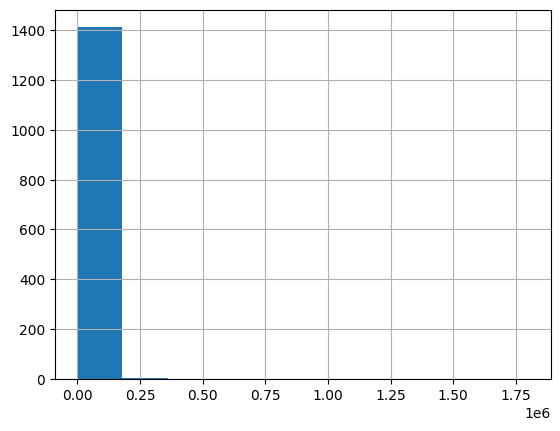

In [137]:
full_trimmed_df['new_uptake'].hist()

In [138]:
# Удаляем строки, где значение в столбце new_uptake больше 95-го процентиля
filtered_trimmed_df = full_trimmed_df[
    full_trimmed_df['new_uptake'] <= full_trimmed_df['new_uptake'].quantile(0.95)
    ]

### Normalisation data

In [139]:
# Приводим текстовые данные к нижнему регистру
text_columns = filtered_trimmed_df.select_dtypes(include=['object']).columns
filtered_trimmed_df[text_columns] = filtered_trimmed_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

<ipython-input-139-2dcd6e069095>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trimmed_df[text_columns] = filtered_trimmed_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [140]:
# Переводим текстовые столбцы в категориальный тип
text_columns = filtered_trimmed_df.select_dtypes(include=['object']).columns
filtered_trimmed_df[text_columns] = filtered_trimmed_df[text_columns].astype('category')

# Получение числовых кодов для категориальных данных
for col in text_columns:
    filtered_trimmed_df[col] = filtered_trimmed_df[col].cat.codes

<ipython-input-140-0173193cb029>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trimmed_df[text_columns] = filtered_trimmed_df[text_columns].astype('category')
<ipython-input-140-0173193cb029>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trimmed_df[col] = filtered_trimmed_df[col].cat.codes


### Important fetures

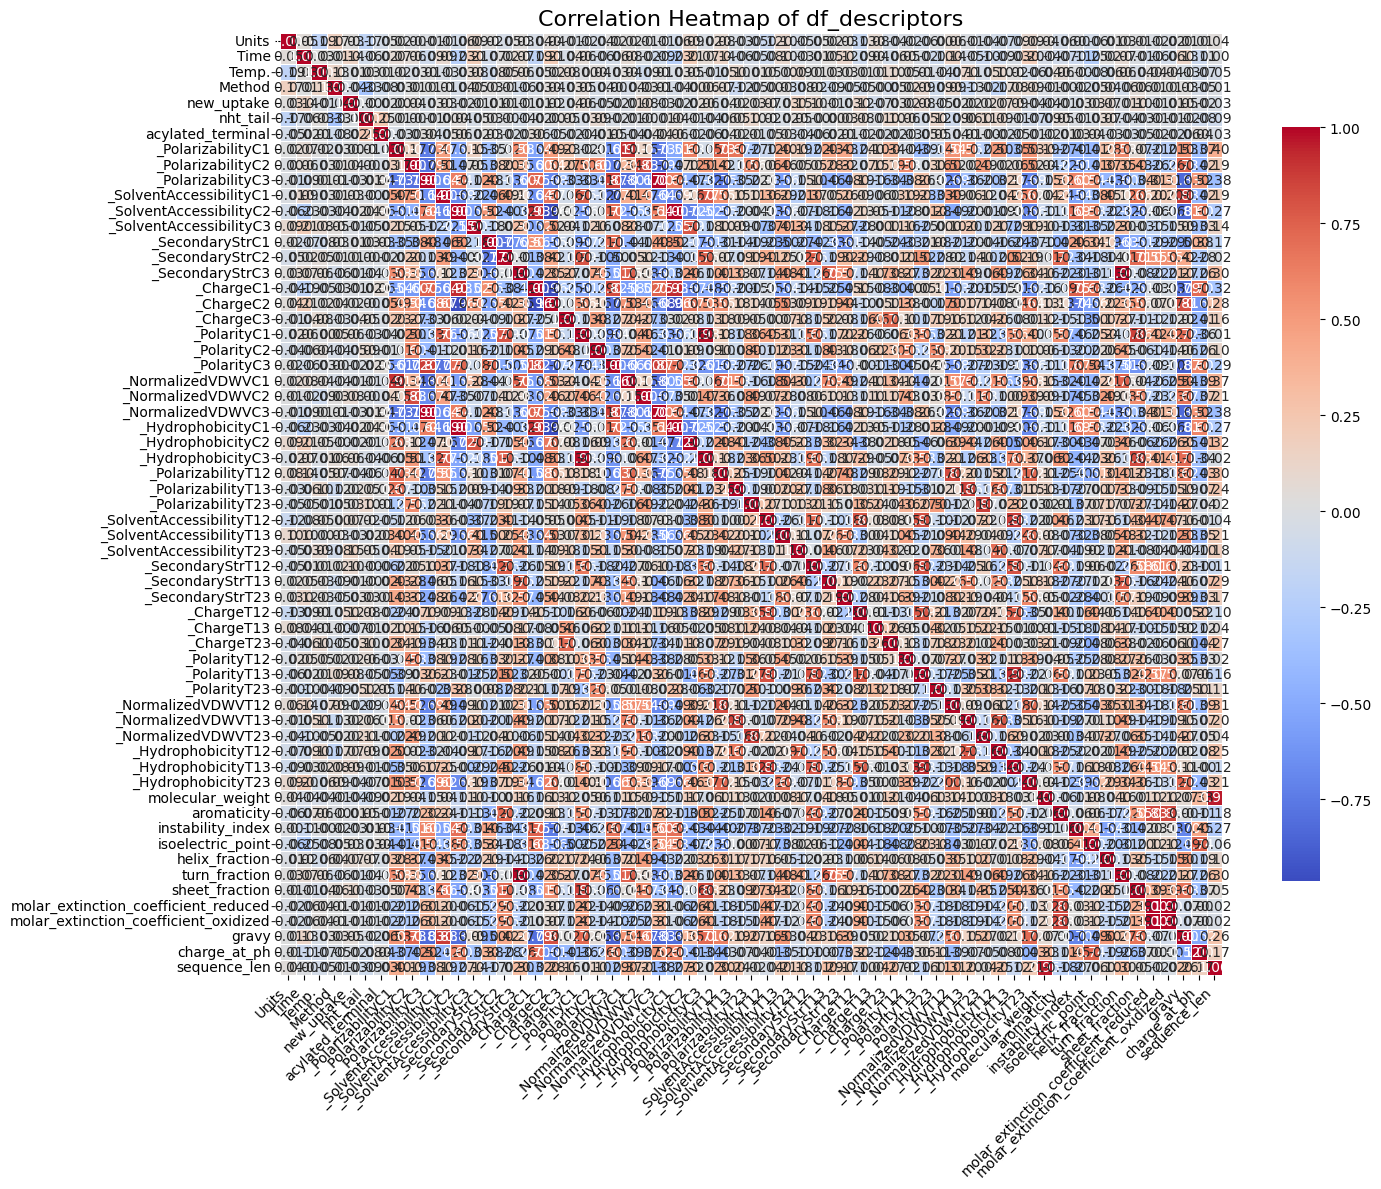

In [141]:
draw_heatmap(filtered_trimmed_df)

In [142]:
important_features = find_significant_correlations(filtered_trimmed_df, 'new_uptake', 0.05)
important_features

['Time',
 '_PolarityC1',
 '_NormalizedVDWVC2',
 '_HydrophobicityC3',
 '_SolventAccessibilityT12',
 '_SolventAccessibilityT23',
 '_SecondaryStrT12',
 '_ChargeT12',
 '_ChargeT13',
 '_PolarityT13',
 '_HydrophobicityT12',
 '_HydrophobicityT13',
 'helix_fraction',
 'sheet_fraction',
 'gravy']

### Building models

In [143]:
# Разделяем датасет на таргет и параметры
X_trimmed = filtered_trimmed_df[important_features]
y_trimmed = filtered_trimmed_df['new_uptake']

In [144]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y_trimmed, test_size=0.2, random_state=42)

#### Random forest

In [145]:
model = RandomForestRegressor(
    n_estimators=500,    # Количество деревьев
    random_state=0
    )
model.fit(X_train, y_train)

# Предсказание и вычисление метрик
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

Mean Squared Error (MSE): 1254164.1809
Mean Absolute Error (MAE): 531.9423
Root Mean Squared Error (RMSE): 1119.8947
R-squared (R^2): 0.0582


#### XGBoost

In [146]:
# Создание и обучение модели XGBoost
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4
    )
xg_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xg_reg.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 1031827.3483
  Mean Absolute Error (MAE): 497.0199
  Root Mean Squared Error (RMSE): 1015.7890
  R-squared (R^2): 0.2252


In [147]:
tune_model_with_correlations(
    filtered_trimmed_df,
    'new_uptake',
    (0.00, 0.2),
    0.01
    )


            ---------------------------------
            Threshold: 0.00 

            MSE: 909578.91 

            MAE: 471.53 

            RMSE: 953.72 

            R^2: 0.32
            

            ---------------------------------
            Threshold: 0.01 

            MSE: 954929.57 

            MAE: 477.95 

            RMSE: 977.20 

            R^2: 0.28
            

            ---------------------------------
            Threshold: 0.02 

            MSE: 914580.42 

            MAE: 461.37 

            RMSE: 956.34 

            R^2: 0.31
            

            ---------------------------------
            Threshold: 0.03 

            MSE: 1080886.78 

            MAE: 504.95 

            RMSE: 1039.66 

            R^2: 0.19
            

            ---------------------------------
            Threshold: 0.04 

            MSE: 1106374.66 

            MAE: 513.67 

            RMSE: 1051.84 

            R^2: 0.17
            

            -------------

#### Best model with Log target

In [148]:
print((filtered_trimmed_df['new_uptake'] <= 0).sum())

31


In [149]:
# Логарифмирование таргета

# Проверка на наличие нулей и отрицательных значений в таргет переменной
print((filtered_trimmed_df['new_uptake'] <= 0).sum())

# Удалить строки с нулями или отрицательными значениями, если такие есть
filtered_trimmed_df = filtered_trimmed_df[filtered_trimmed_df['new_uptake'] > 0]

# Применить логарифм к таргет переменной
filtered_trimmed_df['log_uptake'] = np.log(filtered_trimmed_df['new_uptake'])

31


<ipython-input-149-9687c884eaca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_trimmed_df['log_uptake'] = np.log(filtered_trimmed_df['new_uptake'])


In [150]:
# Разделяем датасет на таргет и параметры
X_trimmed = filtered_trimmed_df.drop(['new_uptake', 'log_uptake'], axis=1)
y_trimmed = filtered_trimmed_df['log_uptake']

In [151]:
# делаем разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y_trimmed, test_size=0.2, random_state=42)

In [152]:
# Создание и обучение модели XGBoost
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4
    )
xg_reg.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xg_reg.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 2.6026
  Mean Absolute Error (MAE): 1.1620
  Root Mean Squared Error (RMSE): 1.6133
  R-squared (R^2): 0.6556


#### Fine-tuning

In [153]:
new_filtered_trimmed_df = filtered_trimmed_df.drop(columns='new_uptake')

In [154]:
tune_regression_with_correlations(
    new_filtered_trimmed_df,
    'log_uptake',
    (0.00, 0.2),
    0.01
    )


            ---------------------------------
            Threshold: 0.00 

            MSE: 2.60 

            MAE: 1.16 

            RMSE: 1.61 

            R^2: 0.66
            

            ---------------------------------
            Threshold: 0.01 

            MSE: 2.52 

            MAE: 1.14 

            RMSE: 1.59 

            R^2: 0.67
            

            ---------------------------------
            Threshold: 0.02 

            MSE: 2.54 

            MAE: 1.14 

            RMSE: 1.60 

            R^2: 0.66
            

            ---------------------------------
            Threshold: 0.03 

            MSE: 2.57 

            MAE: 1.14 

            RMSE: 1.60 

            R^2: 0.66
            

            ---------------------------------
            Threshold: 0.04 

            MSE: 2.40 

            MAE: 1.12 

            RMSE: 1.55 

            R^2: 0.68
            

            ---------------------------------
            Threshold: 0.05 

Берём 0.04 за границу корреляции по модулю, как параметр с наилучшими метриками.

In [155]:
important_features = find_significant_correlations(new_filtered_trimmed_df, 'log_uptake', 0.04)

In [156]:
# Разделяем датасет на таргет и параметры
X_trimmed = new_filtered_trimmed_df[important_features]  # Ваши признаки
y_trimmed = new_filtered_trimmed_df['log_uptake']

In [157]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y_trimmed, test_size=0.2, random_state=42)

In [158]:
# Инициализация модели XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [159]:
# Параметры для поиска
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}

In [160]:
# Использование RandomizedSearchCV для поиска лучших гиперпараметров
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
    )

In [161]:
# Обучение модели
random_search.fit(X_train, y_train)

# Лучшие параметры
best_params = random_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


In [162]:
# Обучение модели с лучшими параметрами
best_model = random_search.best_estimator_

In [163]:
# Предсказания и оценка модели
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f'XGBoost Regression Model:')
print(f'  Mean Squared Error (MSE): {mse:.4f}')
print(f'  Mean Absolute Error (MAE): {mae:.4f}')
print(f'  Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'  R-squared (R^2): {r2:.4f}')

XGBoost Regression Model:
  Mean Squared Error (MSE): 2.2408
  Mean Absolute Error (MAE): 1.0297
  Root Mean Squared Error (RMSE): 1.4969
  R-squared (R^2): 0.7035


## Conclusion

Даже с логарифмированием и fine-tuning, модель обученная на обработанных данных показала результаты хуже.

Можно сказать, что наиболее лучшим вариантом регрессии являются не обработанные данные с логарифмированием таргетной переменной и её обрезкой по 95 перцентилю.

# Genom algoritm

В текущем блоке стоит задача построить алгоритм, который на основе представленных в датасете данных и результатах предсказаний регрессионной модели мог бы генерировать потенциальные CPP.

## Preprocessing

Обрабатываем данные аналогично данным для регрессии

In [295]:
genom_df = pd.concat([
    large_target.reset_index().drop(columns='index') ,
    large_df.reset_index().drop(columns='index')
], axis=1, ignore_index=False)

In [296]:
# Убираем дубли столбцов
genom_df = genom_df.loc[:,~genom_df.columns.duplicated()]
genom_df = genom_df.drop(
    columns=[
        'Unnamed: 0',
        'Cargo',
        'Peptide',
        'Cell line',
        'PubmedID',
        'Uptake',
        'Type',
        'sequence',
        'Sequence'
        ]
    )

In [297]:
# Приводим текстовые данные к нижнему регистру
text_columns = ['Units', 'Method']
genom_df[text_columns] = genom_df[text_columns].applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [299]:
# Переводим текстовые столбцы в категориальный тип
text_columns = ['Units', 'Method']
genom_df[text_columns] = genom_df[text_columns].astype('category')

# Получение числовых кодов для категориальных данных
for col in text_columns:
    genom_df[col] = genom_df[col].cat.codes

Сделаем one-hot кодирование последовательностей для машиночитаемого вида.

In [189]:
genomes = genom_df['cleaned_sequence']
genomes = list(genomes)

In [190]:
# Создание объект OneHotEncoder
encoder = OneHotEncoder(
    categories=[genomes],
    sparse=False,
    handle_unknown='ignore'
    )
encoder.fit(np.array(genom_df['cleaned_sequence']).reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(categories=[['RKKRRQRRR', 'RKKRRQRR', 'RKKRRQR', 'KKRRQRRR',
                           'KRRQRRR', 'RRRQRRKKR', 'AKKRRQRRR', 'RAKRRQRRR',
                           'RKARRQRRR', 'RKKARQRRR', 'RKKRAQRRR', 'RKKRRARRR',
                           'RKKRRQARR', 'RKKRRQRAR', 'RKKRRQRRA', 'RRRRR',
                           'RRRRRR', 'RRRRRRR', 'RRRRRRRR', 'RRRRRRRRR',
                           'KLALKLALKALKAALKLA', 'KALAALLKKWAKLLAALK',
                           'KALAALLKKLAKLLAALK', 'KLALKLALKALKAALK',
                           'KLALKALKAALKLA', 'KLALKLALKALKAA',
                           'KLGLKLGLKGLKGGLKLG', 'KLALKLALKALQAALQLA',
                           'KLALQLALQALQAALQLA', 'QLALQLALQALQAALQLA', ...]],
              handle_unknown='ignore', sparse=False, sparse_output=False)

In [273]:
sequence_to_find = 'RKKRRQRRR'

In [300]:
genom_df.loc[genom_df['cleaned_sequence'] == sequence_to_find][X_test.columns]

Units   Time  Temp.  Method  nht_tail  acylated_terminal  \
0       38   15.0   23.0       5         0                  0   
634     38  960.0   37.0       5         0                  0   
653     38  960.0   37.0       5         0                  0   

     _PolarizabilityC1  _PolarizabilityC2  _PolarizabilityC3  \
0                  0.0              0.111              0.889   
634                0.0              0.111              0.889   
653                0.0              0.111              0.889   

     _SolventAccessibilityC1  ...  instability_index  isoelectric_point  \
0                        0.0  ...         257.444444          11.999968   
634                      0.0  ...         257.444444          11.999968   
653                      0.0  ...         257.444444          11.999968   

     helix_fraction  turn_fraction  sheet_fraction  \
0          0.222222            0.0             0.0   
634        0.222222            0.0             0.0   
653        0.222222            0.0             0.0   

     molar_extinction_coefficient_reduced  \
0                                       0   
634                                     0   
653                                     0   

     molar_extinction_coefficient_oxidized     gravy  charge_at_ph  \
0                                        0 -4.255556      7.758044   
634                                      0 -4.255556      7.758044   
653                                      0 -4.255556      7.758044   

     sequence_len  
0               9  
634             9  
653             9  

[3 rows x 57 columns]

In [191]:
def one_hot_encode_sequence(sequence):
    """
    Преобразует последовательность в one-hot кодирование.

    :param sequence: Строка с последовательностью
    :return: Массив one-hot кодированного представления
    """
    # Преобразование последовательности в массив символов
    sequence_array = np.array(list(sequence)).reshape(-1, 1)

    # Применение OneHotEncoder
    encoded_sequence = encoder.transform(sequence_array)

    # Преобразование в одномерный массив
    return encoded_sequence.flatten()

In [192]:
genom_df['encoded_sequence'] = genom_df['cleaned_sequence'].apply(one_hot_encode_sequence)

## Algorithm building

In [352]:
GENES = genomes
TARGET_LENGTH = 2  # Пример длины последовательности, измените по необходимости

In [239]:
# Наилучшая модель регрессии
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [302]:
# Добавляем в датасет результаты предсказания проницаемости пептида
# как таргет для алгоритма
genom_df['predict'] = best_model.predict(genom_df[X_test.columns])

In [353]:
# Определение функции пригодности
def fitness_function(individual):
    # Преобразование индивидуума в строку
    sequence = ''.join(individual)

    # Берём за fitness_score уровень проницаемости пептида
    try:
      fitness_score = genom_df.loc[
          genom_df['cleaned_sequence'] == sequence_to_find
          ]['predict'].median()
    except:
      fitness_score = genom_df.loc[
          genom_df['cleaned_sequence'] == sequence_to_find
          ]['predict']
    return fitness_score,

# Определение функции мутации
def mutate(individual):
    index = random.randint(0, len(individual) - 1)
    individual[index] = random.choice(GENES)
    return individual,

# Определение функции кроссовера
def crossover(ind1, ind2):
    idx = random.randint(1, len(ind1) - 1)
    ind1[:idx], ind2[:idx] = ind2[:idx], ind1[:idx]
    return ind1, ind2

# Создание классов для DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Максимизация
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_gene", random.choice, GENES)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_gene, n=TARGET_LENGTH)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [371]:
# Инициализация популяции
POPULATION_SIZE = 300
population = toolbox.population(n=POPULATION_SIZE)

# Установите параметры GA
GENERATIONS = 3
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.5

# Запуск алгоритма
for gen in range(GENERATIONS):
    # Отбор
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Кроссовер
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CROSSOVER_RATE:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Мутация
    for mutant in offspring:
        if random.random() < MUTATION_RATE:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Оценка
    invalid_ind = [ind for ind in population + offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Замена популяции
    population[:] = toolbox.select(population + offspring, POPULATION_SIZE)

    # Печать информации о текущем поколении
    fits = [ind.fitness.values[0] for ind in population if ind.fitness.valid]
    if fits:
        length = len(population)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        print(f"Generation {gen}: Min {min(fits)}, Max {max(fits)}, Avg {mean}, Std {std}")

# Вывод лучших индивидуумов
best_individual = tools.selBest(population, 1)[0]
print(f"Best Individual: {''.join(best_individual)}")
print(f"Fitness: {best_individual.fitness.values[0]}")

Generation 0: Min 8.089367866516113, Max 8.089367866516113, Avg 8.089367866516113, Std 7.251217997429632e-07
Generation 1: Min 8.089367866516113, Max 8.089367866516113, Avg 8.089367866516113, Std 7.251217997429632e-07
Generation 2: Min 8.089367866516113, Max 8.089367866516113, Avg 8.089367866516113, Std 7.251217997429632e-07
Best Individual: CPMLKERRRRRRRR
Fitness: 8.089367866516113


In [369]:
# Проверка длины получившейся последовательности
len('RRRRRWWWRRRRRWRWRWRWRW')

22

## Conclusion

Можно сказать, что прототим генетического алгоритма готов и настроен.

С чётом того, что алгоритм не так часто выдаёт последовательности нужной длины, которая является наиболее критичным показателем, в будущих доработках алгоритма стоит учесть и откалибровать его.